# Estimation of simulated VAR by ML

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import random as random
from statsmodels.tsa.arima_process import arma_generate_sample
import tsm as tsm
import pyflux as pf
from scipy.optimize import minimize

np.random.seed(1)

## Simulation of stationary time-series

In [2]:
# Time-series dimension of simulation

nsample = 120

todays_date = datetime.datetime.now().date()
index = pd.date_range(end = todays_date, periods=nsample, freq='Q')
print(index)

DatetimeIndex(['1988-12-31', '1989-03-31', '1989-06-30', '1989-09-30',
               '1989-12-31', '1990-03-31', '1990-06-30', '1990-09-30',
               '1990-12-31', '1991-03-31',
               ...
               '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31',
               '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31',
               '2018-06-30', '2018-09-30'],
              dtype='datetime64[ns]', length=120, freq='Q-DEC')


In [3]:
# Create null data frame

columns = ['X','Y', 'Z']
df = pd.DataFrame(index=index, columns=columns)
df = df.fillna(0) # With 0s rather than NaNs
print(df.head())

            X  Y  Z
1988-12-31  0  0  0
1989-03-31  0  0  0
1989-06-30  0  0  0
1989-09-30  0  0  0
1989-12-31  0  0  0


In [4]:
# Simulation of ARMA processes

for i in np.arange(0,len(df.columns)):
    
    arparams = np.array([1, random.uniform(-0.99,0.99), random.uniform(-0.99,0.99)])
    maparams = np.array([1, random.uniform(-0.99,0.99), random.uniform(-0.99,0.99)])
    
    df.iloc[:,i] = arma_generate_sample(arparams, maparams, nsample)  

print(df.head())

                   X         Y         Z
1988-12-31  1.624345 -0.024617 -0.498214
1989-03-31 -2.443575 -0.764055  0.171572
1989-06-30  0.972692  1.641735 -0.372126
1989-09-30 -0.832131  1.955792 -1.540504
1989-12-31  1.720363 -4.031028  0.314221


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a8684e0>,
      dtype=object)

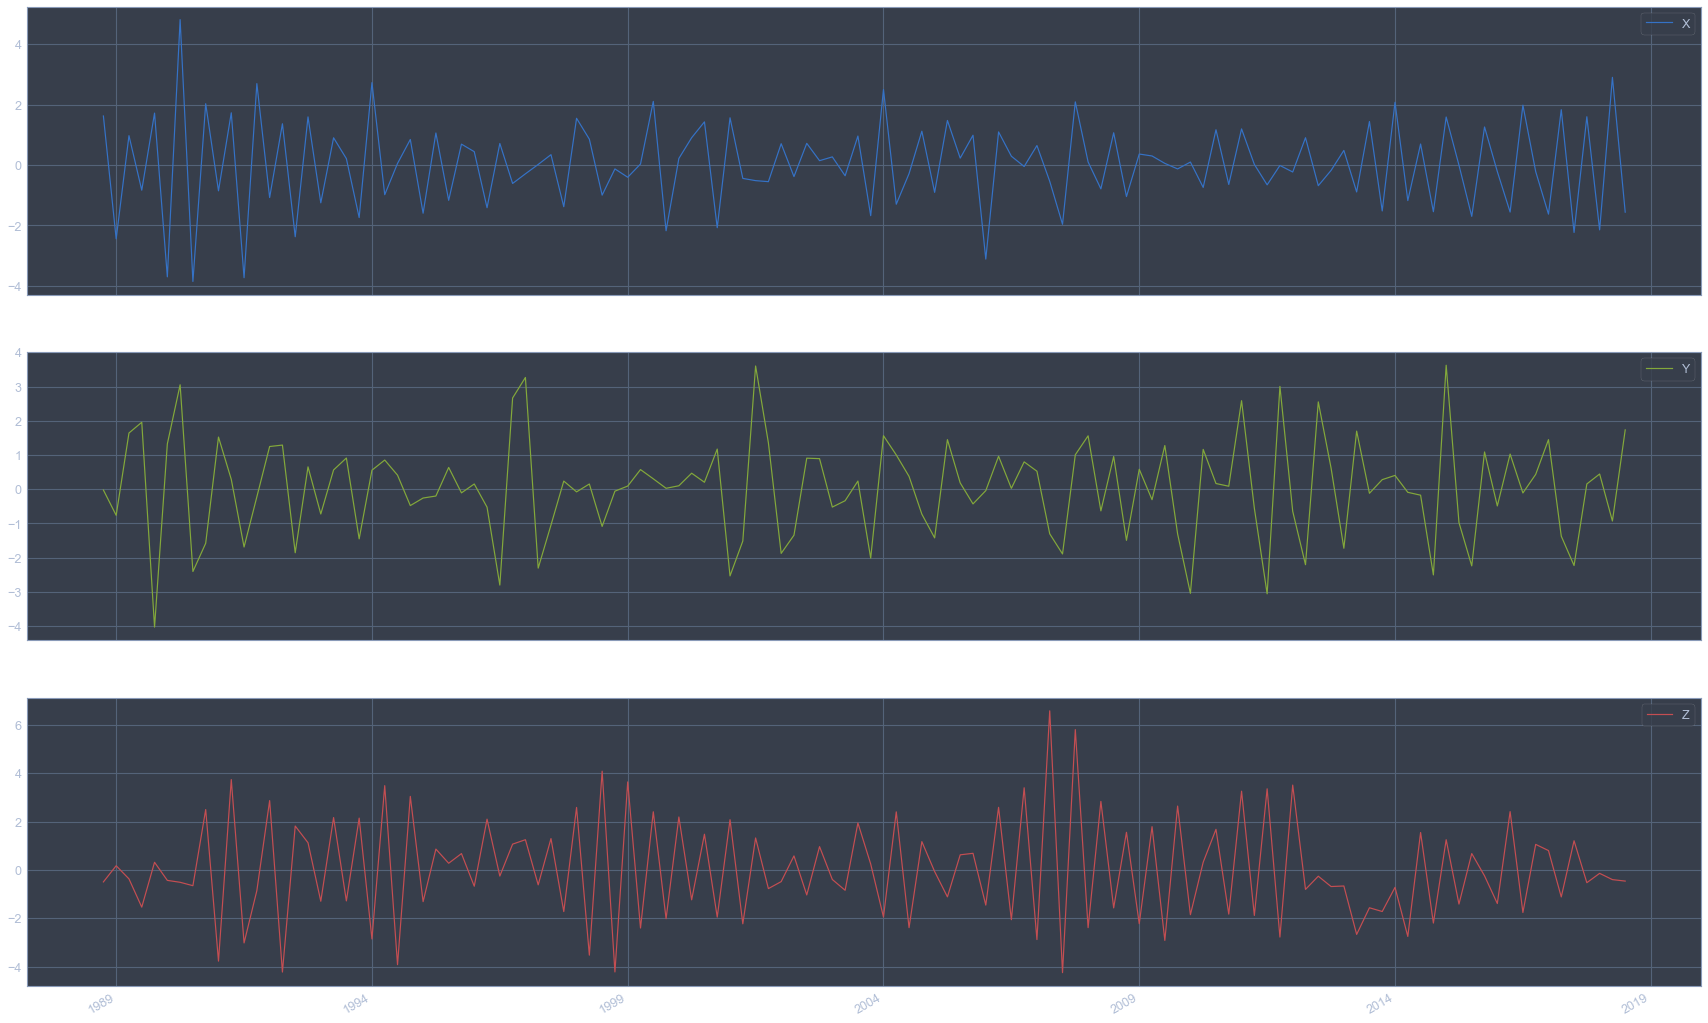

In [5]:
# Plots

df.plot(subplots=True, figsize=(30,20))

## VAR

In [6]:
class VAR:
    """ 
    **** VECTOR AUTOREGRESSION (VAR) MODELS ****
    ----------
    Parameters
    data : pd.DataFrame or np.array
        Field to specify the time series data that will be used.
    lags : int
        Field to specify how many lag terms the model will have. 
    integ : int (default : 0)
        Specifies how many time to difference the dependent variables.
    target : str (pd.DataFrame) or int (np.array) (default : None)
        By default, all columns will be selected as the dependent variables.
    """

    def __init__(self,data,lags,target=None,integ=0):
        
        # Latent Variables
        self.lags = lags
        self.integ = integ
        self.target = target
        self.model_name = "VAR(" + str(self.lags) + ")"
        
        # Format the dependant variables
        self.data = data
        self.values = data.values
        self.index = data.index     
        self.data_name = data.columns.values
        self.T = data.shape[0]
        
        # Format the independent variables
        
        ## TO DO
        
        # Difference data
        X = np.transpose(self.data)
        for order in range(self.integ):
            X = np.asarray([np.diff(i) for i in X])
            self.data_name = np.asarray(["Differenced " + str(i) for i in self.data_name])
        self.data = X.T
        self.ylen = self.data_name.shape[0]
        
        """
        Y : np.array
            Contains the length-adjusted time series (accounting for lags)
        """     

        self.Y = self.data.drop(self.data.index[np.arange(0, self.lags)]).T
        
    def _design(self):
        """ Creates a design matrix
        Z : np.array
        """ 
        
        Z = np.ones(((self.ylen*self.lags+1), (self.T-self.lags)))

        row_count=1
        for lag in range(1, self.lags+1):
            for reg in range(self.ylen):
                Z[row_count, :] = self.data.ix[:,reg][(self.lags-lag):-lag]
                row_count += 1
                
        return(Z)

    def OLS(self):
        """ Creates OLS coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix B
        """         
        
        Z = self._design()
        return np.dot(np.dot(self.Y,np.transpose(Z)),np.linalg.inv(np.dot(Z,np.transpose(Z))))
    
    def _neg_loglike(self, par):
        """ Calculate the MLE value, given the mean vector and variance matrix        
        """
        
        Z = self._design()
        coef = np.reshape(par[0:par.shape[0]-self.ylen], (self.ylen, self.ylen+1))
        coef_var = np.diag(par[-self.ylen:])
        
        logLik = -self.Y.shape[1]*self.ylen*np.log(2*np.pi)*.5 
        - self.Y.shape[1]*np.log(np.abs(np.linalg.det(coef_var)))*.5 
        + .5*np.trace(np.dot(np.dot((self.Y - np.dot(coef,Z)).T,np.linalg.inv(coef_var)),self.Y - np.dot(coef,Z)))
        
        return logLik
    
    def MLE(self):
        """ Creates MLE coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix MLE
        ----------
        It is based on the assumption of normality of errors
        """     

        # Make a list of initial parameter guesses (b0, b1, sd)   
        initParams = np.random.uniform(-10,10, (self.ylen+1)*self.ylen + self.ylen)

        # Run the minimizer
        results = minimize(self._neg_loglike, initParams, method='BFGS')

        # Print the results
        return(results.x)

In [7]:
# Estimate VAR(1) by OLS

# In general

OLS_results = VAR(data = df, lags = 1, target = None, integ = 0).OLS()

# For more clarity

par_names_OLS = ['X Constant','X AR(1)','Y to X AR(1)','Z to X AR(1)','Y Constant','Y AR(1)','X to Y AR(1)','Z to Y AR(1)','Z Constant','Z AR(1)','X to Z AR(1)','Y to Z AR(1)'] 
results_OLS = pd.DataFrame(index = par_names_OLS, data = OLS_results.reshape(-1))
results_OLS.columns = ['Parameters']
results_OLS

,Parameters
X Constant,0.011545
X AR(1),-0.762613
Y to X AR(1),0.118575
Z to X AR(1),-0.027858
Y Constant,0.019724
Y AR(1),-0.058221
X to Y AR(1),-0.220639
Z to Y AR(1),0.003864
Z Constant,0.027844
Z AR(1),-0.055661


In [8]:
# Check with the values for VAR(1) from the pyflux package

pf.VAR(df,1).fit().summary()

VAR(1)                                                                                                    
======================================================= ==================================================
Dependent Variable: X,Y,Z                               Method: OLS                                       
Start Date: 1989-03-31 00:00:00                         Log Likelihood: -573.5313                         
End Date: 2018-09-30 00:00:00                           AIC: 1183.0627                                    
Number of observations: 119                             BIC: 1233.0869                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
X Constant                               0.0115     0.0878     0.1315   0.8954   (-0.1605 | 0.1836)       
X AR(1)                              

In [9]:
# Estimate VAR(1) by MLE

MLE_results = VAR(data = df, lags = 1, target = None, integ = 0).MLE()

# For more clarity

par_names_MLE = par_names_OLS + ['Std of X error','Std of Y error', 'Std of Z error']
results_MLE = pd.DataFrame(index = par_names_MLE, data = MLE_results)
results_MLE.columns = ['Parameters']
results_MLE

,Parameters
X Constant,6.381784
X AR(1),-3.788255
Y to X AR(1),9.648349
Z to X AR(1),-4.667226
Y Constant,0.673067
Y AR(1),-3.710660
X to Y AR(1),8.215457
Z to Y AR(1),-2.668867
Z Constant,-1.328153
Z AR(1),0.245854
